In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import Counter

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LassoCV
from time import time
import warnings
warnings.filterwarnings('ignore')

In [41]:

df = pd.read_csv("../../../our_data/Etap5/Etap3/all_for_FI.csv")
df['mean_h_sin'] = df.apply(lambda row: np.sin((row.mean_h/1)*(np.pi)), axis=1)

In [42]:
df.shape

(16990, 56)

## Spearman correlation between atributes

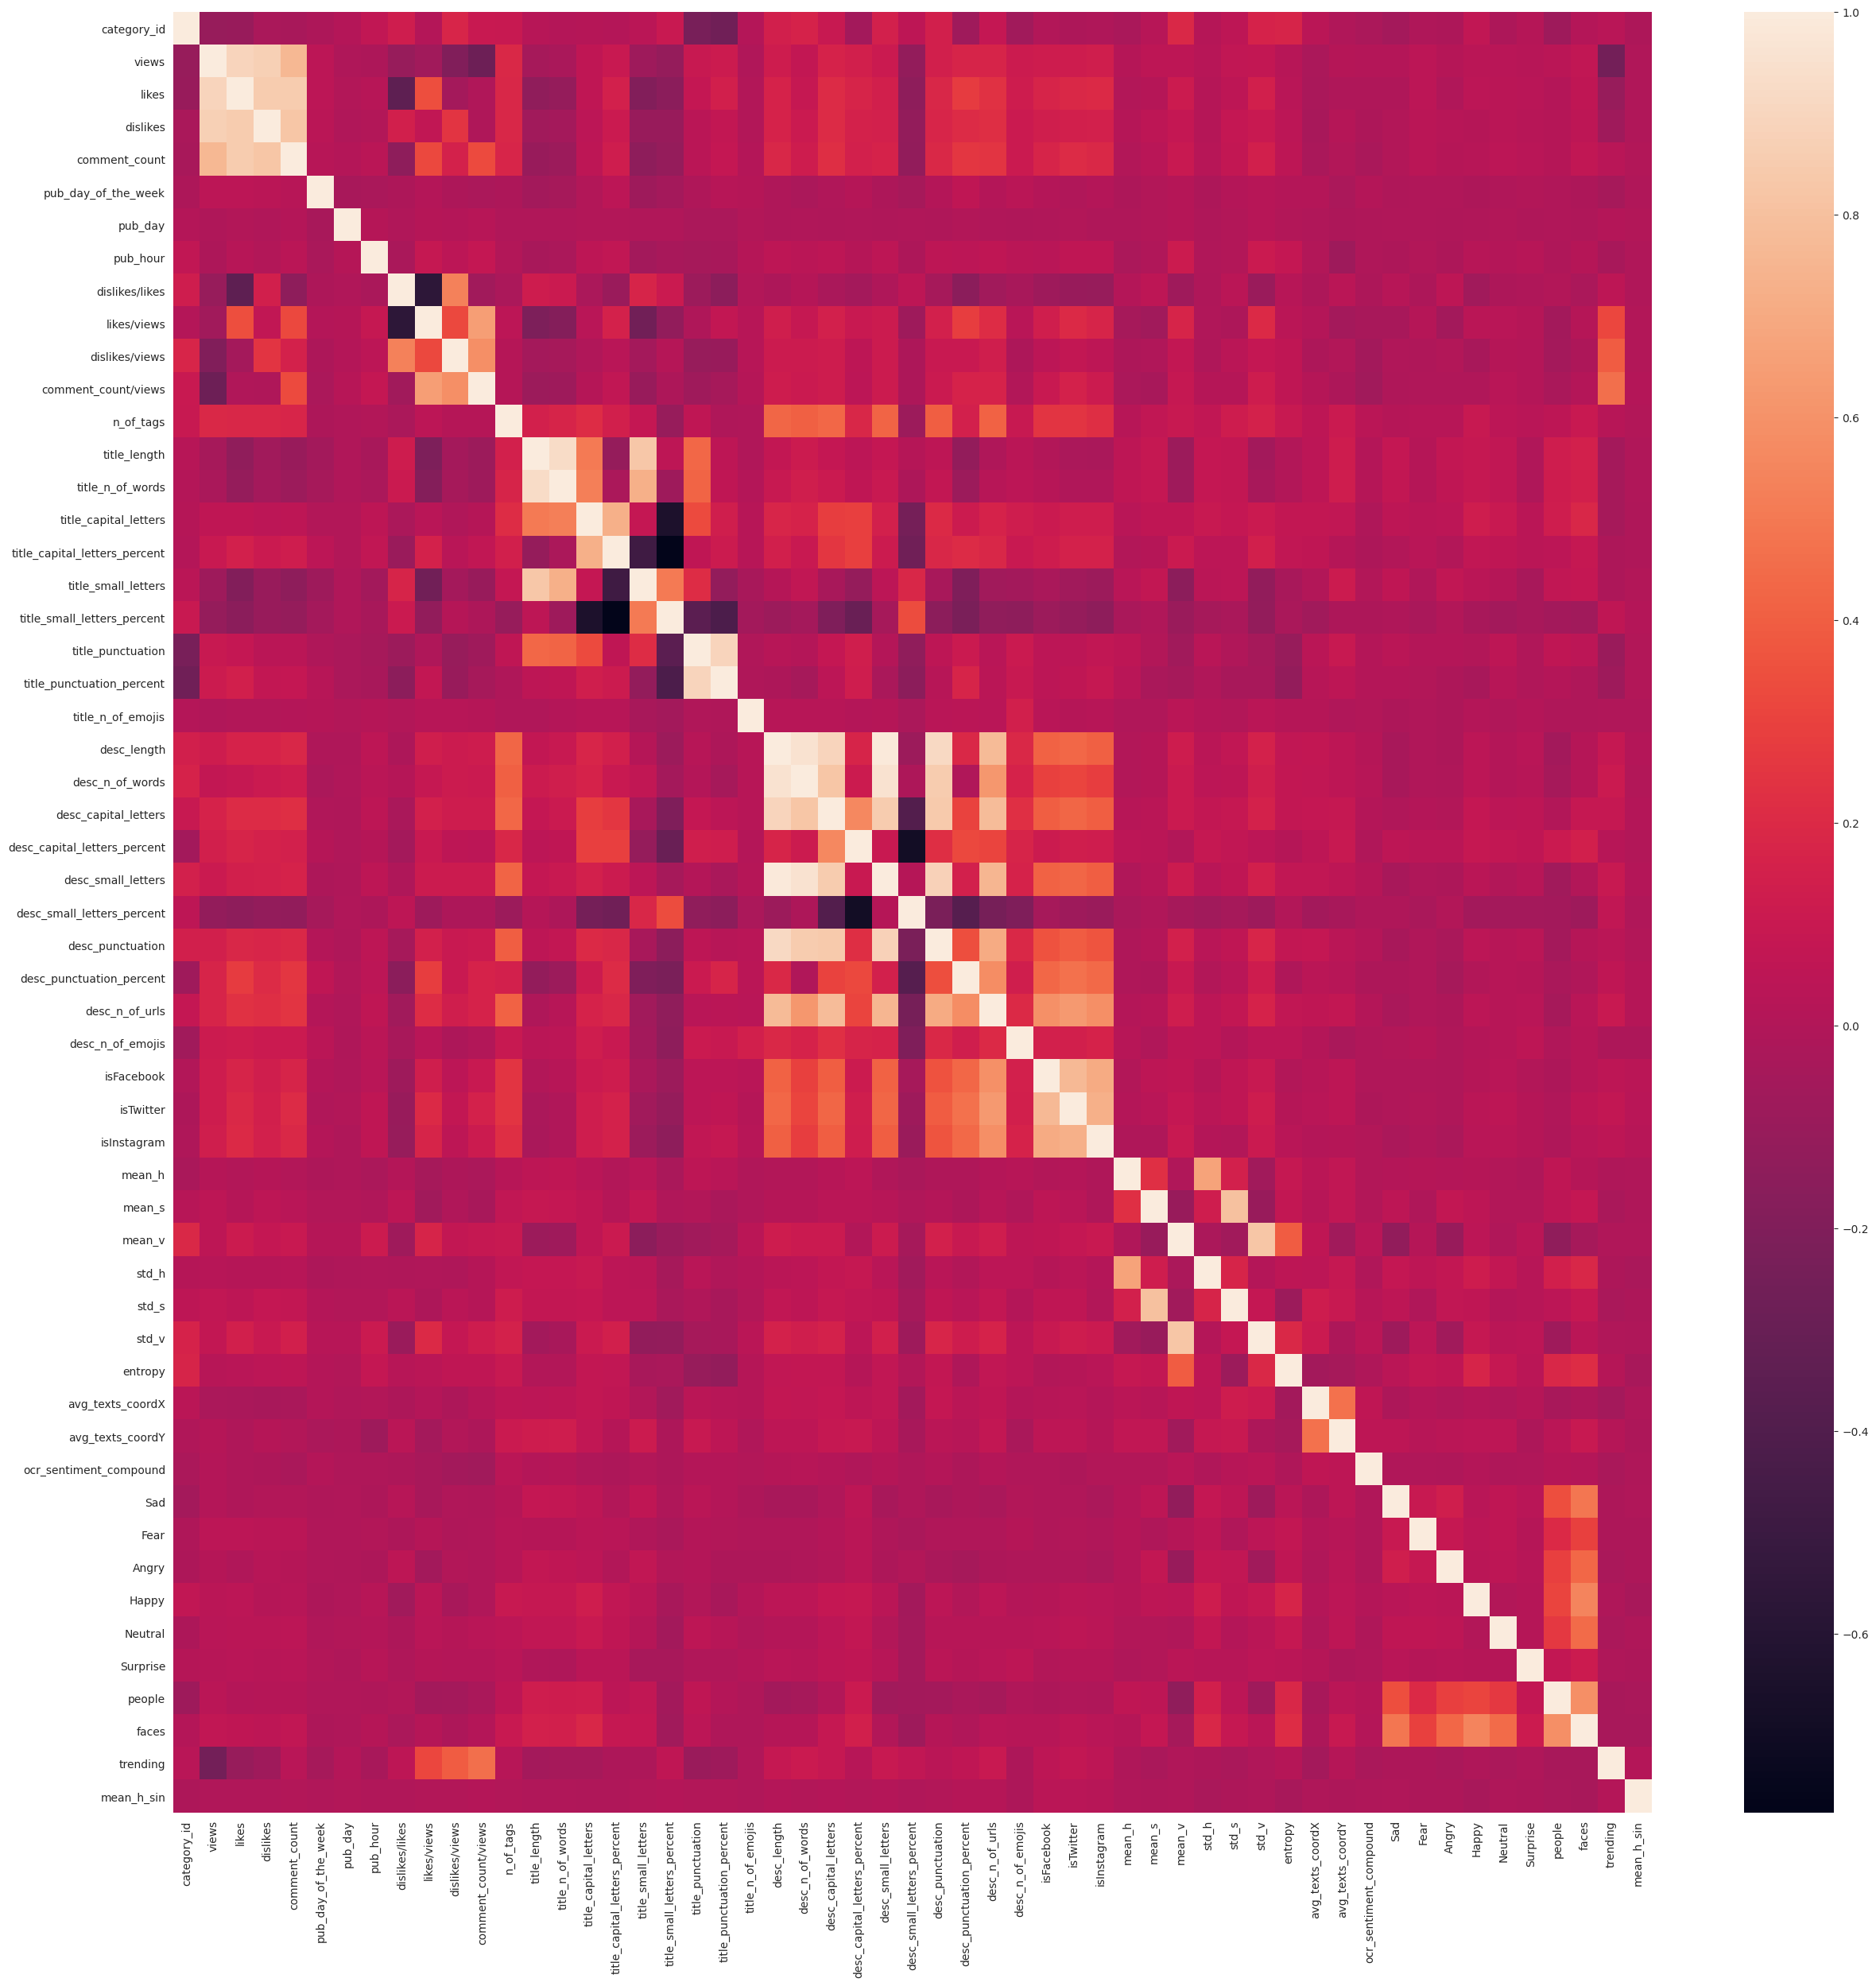

In [43]:
corr = df.corr(method='spearman')
plt.figure(figsize=(30,30),dpi=100)
sns.heatmap(corr)
plt.savefig("../../../our_data/Etap5/Etap3/corr_spearman.pdf")
plt.show()

In [7]:
df.columns

Index(['video_id', 'category_id', 'views', 'likes', 'dislikes',
       'comment_count', 'pub_day_of_the_week', 'pub_day', 'pub_hour',
       'dislikes/likes', 'likes/views', 'dislikes/views',
       'comment_count/views', 'n_of_tags', 'title_length', 'title_n_of_words',
       'title_capital_letters', 'title_capital_letters_percent',
       'title_small_letters', 'title_small_letters_percent',
       'title_punctuation', 'title_punctuation_percent', 'title_n_of_emojis',
       'desc_length', 'desc_n_of_words', 'desc_capital_letters',
       'desc_capital_letters_percent', 'desc_small_letters',
       'desc_small_letters_percent', 'desc_punctuation',
       'desc_punctuation_percent', 'desc_n_of_urls', 'desc_n_of_emojis',
       'isFacebook', 'isTwitter', 'isInstagram', 'mean_h', 'mean_s', 'mean_v',
       'std_h', 'std_s', 'std_v', 'entropy', 'avg_texts_coordX',
       'avg_texts_coordY', 'ocr_sentiment_compound', 'Sad', 'Fear', 'Angry',
       'Happy', 'Neutral', 'Surprise', 'people',

In [44]:
pd.set_option('display.max_columns', None)

def prepeareData(df):
    df = df[ df['trending'].notna() ]
    y = df.loc[:,'trending']
    X  = df.loc[:, df.columns != 'trending']
    X = X.select_dtypes(include=np.number)
    X = X.fillna(-1)
    return X, y


def getFI_RForest(X,y,printF= True,plot = True):
    forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=0)

    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    df = pd.DataFrame(np.dstack([importances,X.columns])[0])
    if plot:    
        plt.figure(figsize=(10,10))

        plt.title("Feature importances")
        plt.bar(range(X.shape[1]), importances[indices],
                color="r", yerr=std[indices], align="center")
#         plt.bar(range(X.shape[1]), x=np.arange(0,len(df)),
#                 color="r", yerr=std[indices], align="center")
#         plt.xticks(range(X.shape[1]), indices)
        plt.xlim([-1, X.shape[1]])
        plt.show()
    if printF: 
        print("Feature ranking:")
        for f in range(X.shape[1]):
            print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

    
    return df.sort_values(by=0,ascending=False)

def getFI_Bagging(X,y,printF= True,plot = True):
    clf = BaggingClassifier(DecisionTreeClassifier())
    clf.fit(X, y)

    feature_importances = np.mean([
        tree.feature_importances_ for tree in clf.estimators_
    ], axis=0)

    df = pd.DataFrame(np.dstack([feature_importances,X.columns])[0])
    
    indices = np.argsort(feature_importances)[::-1]

    if plot:
        
        plt.figure(figsize=(10,10))
            
        plt.title("Feature importances")
        plt.bar(range(X.shape[1]), feature_importances[indices],
                color="r",  align="center")
#         plt.bar(range(X.shape[1]),
#                 color="r",  align="center")
#         plt.xticks(range(X.shape[1]), indices)
        plt.xlim([-1, X.shape[1]])
        plt.show()
    if printF: 
        print("Feature ranking:")
        for f in range(X.shape[1]):
            print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], feature_importances[indices[f]]))
            
    return df.sort_values(by=0,ascending=False)

def selectFromModelSVC(X,y,printF= True,plot = True):
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
    model = SelectFromModel(lsvc, prefit=True)
    X_new = model.transform(X)
    feature_idx = model.get_support()
    feature_name = X.columns[feature_idx]    
    if printF:
        print("Before: "+ str(X.shape))
        print("After: "+ str(X_new.shape))        
        print(feature_name)
    return feature_name
def getFILasso(X,y,printF= True,plot = True):
    lasso = LassoCV().fit(X, y)
    importance = np.abs(lasso.coef_)
    feature_names = np.array(X.columns)

    df = pd.DataFrame(np.dstack([importance,X.columns])[0])
    df = df.sort_values(by=0,ascending=False)
    if plot:
        plt.figure(figsize=(10,10))

        plt.bar(height=df[0], x=np.arange(0,len(df)))
        plt.title("Feature importances via coefficients")
        plt.show()
    if printF:
        pd.set_option('display.max_rows', None)        
        print(df.sort_values(by=0,ascending=False))
        pd.set_option('display.max_rows', 20)        

    return df.sort_values(by=0,ascending=False)
    
    


# Feature importance

In [45]:
X, y = prepeareData(df)
print(df.shape)
df

(16990, 56)


,video_id,category_id,views,likes,dislikes,comment_count,pub_day_of_the_week,pub_day,pub_hour,dislikes/likes,likes/views,dislikes/views,comment_count/views,n_of_tags,title_length,title_n_of_words,title_capital_letters,title_capital_letters_percent,title_small_letters,title_small_letters_percent,title_punctuation,title_punctuation_percent,title_n_of_emojis,desc_length,desc_n_of_words,desc_capital_letters,desc_capital_letters_percent,desc_small_letters,desc_small_letters_percent,desc_punctuation,desc_punctuation_percent,desc_n_of_urls,desc_n_of_emojis,isFacebook,isTwitter,isInstagram,mean_h,mean_s,mean_v,std_h,std_s,std_v,entropy,avg_texts_coordX,avg_texts_coordY,ocr_sentiment_compound,Sad,Fear,Angry,Happy,Neutral,Surprise,people,faces,trending,mean_h_sin
0,tOpTQ3Fuf9s,10,0.522451,2.943601,0.007986,0.920714,1.779362,0.793851,-0.219590,-0.181688,-0.054449,-0.065806,-0.021313,2.716688,0.289196,0.011139,-0.400511,-0.516403,-0.545520,-1.017732,1.961436,1.700950,-0.098746,-0.997704,-0.870119,-0.630365,0.819610,-1.023449,-1.317247,-0.602039,-0.784991,-0.887171,-0.248385,0,0,0,0.974207,-1.275044,-0.080489,1.107219,-1.075142,-0.742505,0.256621,-1.185383,-1.423955,-0.115386,-0.442328,-0.291643,-0.403087,-0.553750,-0.481588,-0.11798,2.872551,-0.781681,0,0.080941
1,k0DqRstCgj4,10,2.073490,8.162990,0.147273,4.719335,-1.471729,1.261720,0.231302,-0.177401,-0.229012,-0.065349,-0.021312,2.797176,-0.361339,-0.268399,-0.164737,-0.053177,-1.325168,-1.870503,3.525294,4.447726,-0.098746,-0.912770,-0.709958,-0.427639,2.439801,-1.007130,-2.648998,-0.498959,-0.371932,-0.887171,-0.248385,0,0,0,-0.200788,1.089185,-1.525329,1.542963,1.556973,-1.308896,-1.477956,0.050411,1.038159,-0.115386,-0.442328,-0.291643,-0.403087,-0.553750,-0.481588,-0.11798,0.517372,-0.781681,0,-0.589786
2,1CYH4F1KCw8,10,1.214069,6.528692,0.137712,3.771792,-0.388032,0.325981,0.231302,-0.175135,-0.056146,-0.062976,-0.021310,2.716688,0.639484,0.290677,-0.164737,-0.415426,-0.480550,-1.146115,3.525294,2.679282,-0.098746,-0.912770,-0.709958,-0.427639,2.439801,-1.007130,-2.648998,-0.498959,-0.371932,-0.887171,-0.248385,0,0,0,1.402899,0.107901,0.546908,-0.526075,0.621568,0.829999,0.630587,0.050411,1.042783,-0.115386,-0.442328,-0.291643,-0.403087,-0.553750,-0.481588,-0.11798,1.348612,-0.781681,0,-0.953832
3,UdjEoGzXxmI,10,0.163359,1.634717,-0.009439,0.692539,-1.471729,0.910818,0.231302,-0.181130,0.239992,-0.063887,-0.021308,-0.985750,0.289196,-0.547937,-0.046850,-0.218131,-0.610491,-1.109026,4.567867,4.127820,-0.098746,-0.997704,-0.887915,-0.606038,1.490034,-1.025262,-1.425519,-0.516139,0.653525,-0.887171,-0.248385,0,0,0,-0.604300,-1.483410,0.964161,-0.216254,-1.422896,0.197303,-0.068919,-1.185383,-1.423955,-0.115386,-0.442328,-0.291643,-0.403087,-0.553750,-0.481588,-0.11798,0.932992,-0.781681,0,-0.946795
4,cD8SYW8rjaQ,10,0.968084,5.297738,0.086113,3.887045,1.779362,-1.311564,0.231302,-0.177162,-0.050280,-0.063806,-0.021307,0.221566,-0.961833,-0.827475,0.188925,0.912821,-1.909904,-2.934909,1.961436,3.976141,-0.098746,-0.912770,-0.709958,-0.427639,2.439801,-1.007130,-2.648998,-0.498959,-0.371932,-0.887171,-0.248385,0,0,0,-0.907744,0.488066,-1.120820,-0.681140,0.645923,-0.690448,-0.005110,-0.087127,0.290278,-0.115386,2.232788,-0.291643,-0.403087,-0.553750,2.763068,-0.11798,1.071532,1.356148,0,-0.285790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16985,zvFQWPEuNJA,24,-0.069865,-0.173854,-0.030374,-0.164515,-1.471729,-0.726727,-0.520185,-0.113742,-0.289246,-0.047629,-0.021307,0.463030,-1.111957,-1.107013,-0.518398,-0.039853,-0.740432,0.295015,-0.644996,-0.257283,-0.098746,0.427030,0.215417,0.026468,-0.301487,0.541335,0.422330,-0.138178,0.368561,1.598099,-0.248385,1,1,1,-1.275016,0.988842,0.269349,-1.262519,0.868762,1.260938,0.320593,-0.246367,0.630284,1.509876,0.895230,-0.291643,-0.403087,-0.553750,-0.481588,-0.11

## Feature Importance based on Random Forest

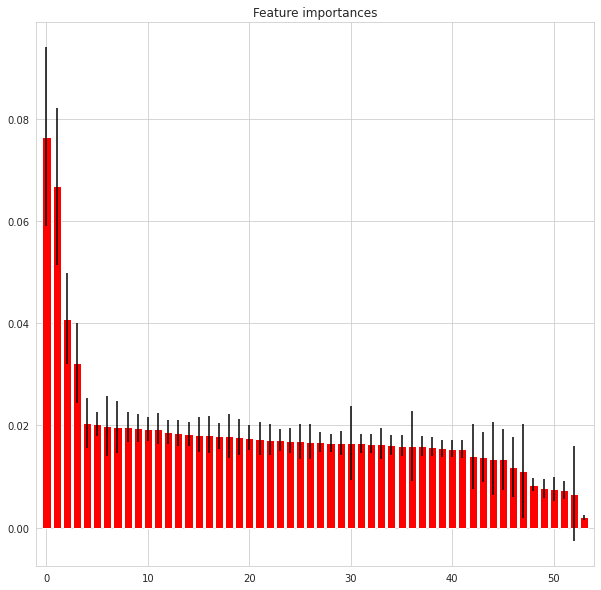

Feature ranking:
1. feature likes/views (0.076574)
2. feature comment_count/views (0.066832)
3. feature dislikes/views (0.040925)
4. feature views (0.032262)
5. feature avg_texts_coordX (0.020527)
6. feature dislikes/likes (0.020277)
7. feature avg_texts_coordY (0.019848)
8. feature mean_h_sin (0.019735)
9. feature likes (0.019722)
10. feature category_id (0.019481)
11. feature pub_hour (0.019393)
12. feature desc_n_of_words (0.019392)
13. feature desc_small_letters_percent (0.018687)
14. feature n_of_tags (0.018472)
15. feature desc_punctuation_percent (0.018261)
16. feature desc_small_letters (0.018210)
17. feature desc_length (0.018162)
18. feature desc_n_of_urls (0.017939)
19. feature mean_s (0.017857)
20. feature std_s (0.017731)
21. feature title_punctuation (0.017622)
22. feature std_v (0.017393)
23. feature mean_v (0.017210)
24. feature desc_punctuation (0.017086)
25. feature title_punctuation_percent (0.017049)
26. feature mean_h (0.016893)
27. feature std_h (0.016842)
28. fea

In [46]:
r1 = getFI_RForest(X,y)

## Feature Importance based on Bagging + Decision tree

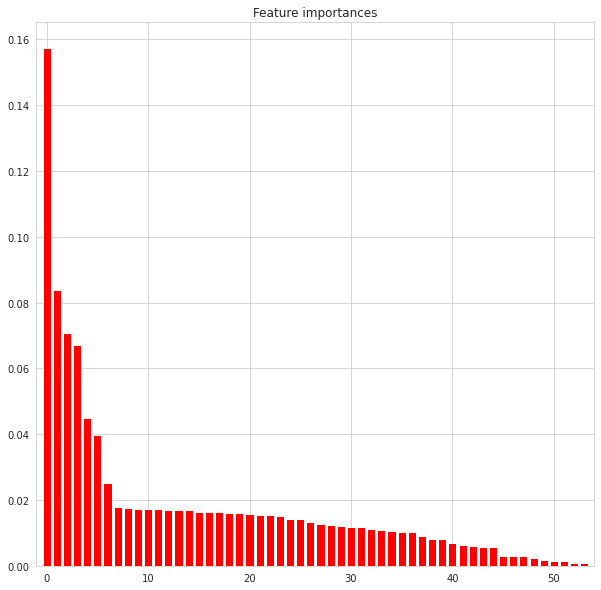

Feature ranking:
1. feature dislikes/views (0.157383)
2. feature likes/views (0.083814)
3. feature views (0.070709)
4. feature comment_count/views (0.067083)
5. feature mean_h_sin (0.044786)
6. feature n_of_tags (0.039740)
7. feature desc_small_letters_percent (0.025201)
8. feature likes (0.017765)
9. feature dislikes/likes (0.017682)
10. feature pub_hour (0.017379)
11. feature entropy (0.017160)
12. feature dislikes (0.017160)
13. feature desc_punctuation_percent (0.017031)
14. feature title_capital_letters_percent (0.016946)
15. feature desc_capital_letters_percent (0.016813)
16. feature mean_s (0.016438)
17. feature std_v (0.016365)
18. feature std_s (0.016346)
19. feature desc_length (0.016166)
20. feature title_small_letters_percent (0.015901)
21. feature title_punctuation_percent (0.015858)
22. feature mean_v (0.015484)
23. feature desc_n_of_words (0.015400)
24. feature std_h (0.015057)
25. feature category_id (0.014370)
26. feature avg_texts_coordY (0.014315)
27. feature desc_pu

In [47]:
r3 = getFI_Bagging(X,y)

## Feature Importance based on LassoCV

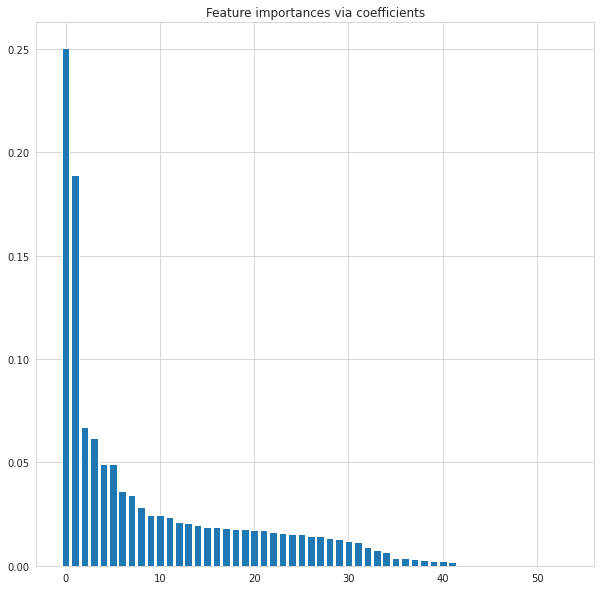

              0                              1
9       0.25039                    likes/views
10     0.188879                 dislikes/views
23    0.0671749                desc_n_of_words
2     0.0618791                          likes
8     0.0493721                 dislikes/likes
22    0.0492754                    desc_length
19    0.0359464              title_punctuation
42    0.0342427               avg_texts_coordX
49    0.0283506                        Neutral
4     0.0244947                  comment_count
48    0.0243724                          Happy
52    0.0236334                          faces
28    0.0211489               desc_punctuation
30    0.0206446                 desc_n_of_urls
44     0.019738         ocr_sentiment_compound
24    0.0186877           desc_capital_letters
3     0.0185657                       dislikes
47     0.018412                          Angry
7     0.0178128                       pub_hour
27    0.0177427     desc_small_letters_percent
53    0.01750

In [48]:
r2 = getFILasso(X,y)

## Selecting features based on  LinearSVC and sklearn SelectFromModel

In [49]:
r4 = selectFromModelSVC(X,y)

Before: (16990, 54)
After: (16990, 44)
Index(['category_id', 'views', 'likes', 'comment_count', 'pub_day_of_the_week',
       'pub_hour', 'dislikes/likes', 'likes/views', 'dislikes/views',
       'comment_count/views', 'n_of_tags', 'title_n_of_words',
       'title_capital_letters_percent', 'title_small_letters',
       'title_punctuation', 'title_punctuation_percent', 'desc_length',
       'desc_n_of_words', 'desc_capital_letters',
       'desc_capital_letters_percent', 'desc_small_letters_percent',
       'desc_punctuation', 'desc_punctuation_percent', 'desc_n_of_urls',
       'desc_n_of_emojis', 'isTwitter', 'mean_s', 'mean_v', 'std_h', 'std_s',
       'std_v', 'entropy', 'avg_texts_coordX', 'avg_texts_coordY',
       'ocr_sentiment_compound', 'Sad', 'Fear', 'Angry', 'Happy', 'Neutral',
       'Surprise', 'people', 'faces', 'mean_h_sin'],
      dtype='object')


In [50]:
df.loc[df['trending'] == 1]

,video_id,category_id,views,likes,dislikes,comment_count,pub_day_of_the_week,pub_day,pub_hour,dislikes/likes,likes/views,dislikes/views,comment_count/views,n_of_tags,title_length,title_n_of_words,title_capital_letters,title_capital_letters_percent,title_small_letters,title_small_letters_percent,title_punctuation,title_punctuation_percent,title_n_of_emojis,desc_length,desc_n_of_words,desc_capital_letters,desc_capital_letters_percent,desc_small_letters,desc_small_letters_percent,desc_punctuation,desc_punctuation_percent,desc_n_of_urls,desc_n_of_emojis,isFacebook,isTwitter,isInstagram,mean_h,mean_s,mean_v,std_h,std_s,std_v,entropy,avg_texts_coordX,avg_texts_coordY,ocr_sentiment_compound,Sad,Fear,Angry,Happy,Neutral,Surprise,people,faces,trending,mean_h_sin
8481,-3VBPAZPTQI,22,-0.082890,-0.185615,-0.036171,-0.195047,0.695665,1.612623,0.231302,-0.161132,0.514782,-0.046448,-0.021295,-0.502824,-0.161174,-0.268399,3.371875,3.392213,-1.909904,-2.934909,-0.123710,-0.058531,-0.098746,3.983482,2.075065,3.748525,0.588375,3.614694,-0.317396,2.456012,0.959375,5.522209,-0.248385,0,1,1,-1.453392,-0.311721,0.583510,-1.321724,-0.397531,-0.196766,0.469784,-1.185383,-1.423955,-0.115386,-0.442328,-0.291643,1.241564,0.610413,-0.481588,-0.11798,-0.313867,0.287234,1,0.989299
8482,-43MBOJnVks,24,-0.074224,-0.200115,-0.033171,-0.177684,-0.929881,-0.258857,0.531897,-0.103003,-0.395371,-0.050399,-0.021306,0.784981,-0.911792,-0.827475,1.603569,2.909215,-1.909904,-2.934909,0.397577,1.303826,-0.098746,2.451085,2.884768,1.177954,-0.198062,2.731670,0.434478,1.803169,-0.525064,-0.887171,-0.248385,0,0,0,0.136210,-1.319733,0.019152,-0.587651,-1.304023,-1.167200,-0.210938,-1.185383,-1.423955,-0.115386,-0.442328,-0.291643,1.241564,-0.553750,-0.481588,-0.11798,-0.452407,-0.247224,1,0.414977
8483,-5WBCrazSfg,17,-0.083848,-0.216914,-0.037866,-0.203962,-1.471729,1.378688,0.832492,-0.164479,-0.143788,-0.059781,-0.021296,0.865469,0.939731,0.849753,-0.282624,-0.564695,0.948805,0.336030,1.440149,0.764871,5.401882,-0.404364,-0.354045,-0.143822,0.495276,-0.408777,0.028589,-0.378698,-0.067006,-0.363956,-0.248385,1,1,1,-1.101069,-0.611874,-0.225399,-0.990396,-0.007340,0.816029,0.373197,0.935174,1.243913,1.161533,-0.442328,-0.291643,-0.403087,0.610413,-0.481588,-0.11798,-0.452407,-0.247224,1,0.312209
8484,-5aaJJQFvOg,10,-0.075133,0.145823,-0.024492,0.026077,-0.388032,0.676883,1.283384,-0.168693,3.099048,-0.017434,-0.021259,-0.905263,-0.361339,-0.268399,-0.046850,0.075623,-0.350608,-0.096491,0.397577,0.675046,-0.098746,-0.181862,-0.514206,-0.022186,0.330109,-0.149490,0.232880,-0.430239,0.889510,0.682473,-0.248385,1,1,0,2.225753,-0.268056,0.301262,1.245253,0.018124,0.688371,0.584025,-1.185383,-1.423955,-0.115386,0.895230,2.639269,-0.403087,2.938738,2.763068,-0.11798,0.378833,2.959520,1,0.651245
8485,-7tSTUR7FG0,10,-0.060070,0.468660,-0.033035,0.243822,-0.929881,1.378688,-0.219590,-0.185475,2.559324,-0.059737,-0.021268,2.394737,-0.911792,-0.547937,-0.046850,0.504955,-1.195227,-1.200321,-0.123710,0.465452,-0.098746,-0.684287,-0.763345,-0.435748,0.168766,-0.698887,-0.105315,-0.550499,1.410593,-0.102349,-0.248385,1,1,1,-0.138693,-1.672758,0.585839,0.179871,-1.331185,-0.158244,0.186482,-1.185383,-1.423955,-0.115386,-0.442328,-0.291643,-0.403087,-0.553750,-0.481588,-0.11798,0.655912,-0.781681,1,-0.422059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16985,zvFQWPEuNJA,24,-0.069865,-0.173854,-0.030374,-0.164515,-1.471729,-0.726727,-0.520185,-0.113742,-0.289246,-0.047629,-0.021307,0.463030,-1.111957,-1.107013,-0.518398,-0.039853,-0.740432,0.295015,-0.644996,-0.257283,-0.098746,0.427030,0.215417,0.026468,-0.301487,0.541335,0.422330,-0.138178,0.368561,1.598099,-0.248385,1,1,1,-1.275016,0.988842,0.269349,-1.262519,0.868762,1.260938,0.320593,-0.246367,0.630284,1.509876,0.895230,-0.291643,-0.403087,-0.553750,-0.481

In [51]:
df.loc[df['trending'] == 0]

,video_id,category_id,views,likes,dislikes,comment_count,pub_day_of_the_week,pub_day,pub_hour,dislikes/likes,likes/views,dislikes/views,comment_count/views,n_of_tags,title_length,title_n_of_words,title_capital_letters,title_capital_letters_percent,title_small_letters,title_small_letters_percent,title_punctuation,title_punctuation_percent,title_n_of_emojis,desc_length,desc_n_of_words,desc_capital_letters,desc_capital_letters_percent,desc_small_letters,desc_small_letters_percent,desc_punctuation,desc_punctuation_percent,desc_n_of_urls,desc_n_of_emojis,isFacebook,isTwitter,isInstagram,mean_h,mean_s,mean_v,std_h,std_s,std_v,entropy,avg_texts_coordX,avg_texts_coordY,ocr_sentiment_compound,Sad,Fear,Angry,Happy,Neutral,Surprise,people,faces,trending,mean_h_sin
0,tOpTQ3Fuf9s,10,0.522451,2.943601,0.007986,0.920714,1.779362,0.793851,-0.219590,-0.181688,-0.054449,-0.065806,-0.021313,2.716688,0.289196,0.011139,-0.400511,-0.516403,-0.545520,-1.017732,1.961436,1.700950,-0.098746,-0.997704,-0.870119,-0.630365,0.819610,-1.023449,-1.317247,-0.602039,-0.784991,-0.887171,-0.248385,0,0,0,0.974207,-1.275044,-0.080489,1.107219,-1.075142,-0.742505,0.256621,-1.185383,-1.423955,-0.115386,-0.442328,-0.291643,-0.403087,-0.553750,-0.481588,-0.11798,2.872551,-0.781681,0,0.080941
1,k0DqRstCgj4,10,2.073490,8.162990,0.147273,4.719335,-1.471729,1.261720,0.231302,-0.177401,-0.229012,-0.065349,-0.021312,2.797176,-0.361339,-0.268399,-0.164737,-0.053177,-1.325168,-1.870503,3.525294,4.447726,-0.098746,-0.912770,-0.709958,-0.427639,2.439801,-1.007130,-2.648998,-0.498959,-0.371932,-0.887171,-0.248385,0,0,0,-0.200788,1.089185,-1.525329,1.542963,1.556973,-1.308896,-1.477956,0.050411,1.038159,-0.115386,-0.442328,-0.291643,-0.403087,-0.553750,-0.481588,-0.11798,0.517372,-0.781681,0,-0.589786
2,1CYH4F1KCw8,10,1.214069,6.528692,0.137712,3.771792,-0.388032,0.325981,0.231302,-0.175135,-0.056146,-0.062976,-0.021310,2.716688,0.639484,0.290677,-0.164737,-0.415426,-0.480550,-1.146115,3.525294,2.679282,-0.098746,-0.912770,-0.709958,-0.427639,2.439801,-1.007130,-2.648998,-0.498959,-0.371932,-0.887171,-0.248385,0,0,0,1.402899,0.107901,0.546908,-0.526075,0.621568,0.829999,0.630587,0.050411,1.042783,-0.115386,-0.442328,-0.291643,-0.403087,-0.553750,-0.481588,-0.11798,1.348612,-0.781681,0,-0.953832
3,UdjEoGzXxmI,10,0.163359,1.634717,-0.009439,0.692539,-1.471729,0.910818,0.231302,-0.181130,0.239992,-0.063887,-0.021308,-0.985750,0.289196,-0.547937,-0.046850,-0.218131,-0.610491,-1.109026,4.567867,4.127820,-0.098746,-0.997704,-0.887915,-0.606038,1.490034,-1.025262,-1.425519,-0.516139,0.653525,-0.887171,-0.248385,0,0,0,-0.604300,-1.483410,0.964161,-0.216254,-1.422896,0.197303,-0.068919,-1.185383,-1.423955,-0.115386,-0.442328,-0.291643,-0.403087,-0.553750,-0.481588,-0.11798,0.932992,-0.781681,0,-0.946795
4,cD8SYW8rjaQ,10,0.968084,5.297738,0.086113,3.887045,1.779362,-1.311564,0.231302,-0.177162,-0.050280,-0.063806,-0.021307,0.221566,-0.961833,-0.827475,0.188925,0.912821,-1.909904,-2.934909,1.961436,3.976141,-0.098746,-0.912770,-0.709958,-0.427639,2.439801,-1.007130,-2.648998,-0.498959,-0.371932,-0.887171,-0.248385,0,0,0,-0.907744,0.488066,-1.120820,-0.681140,0.645923,-0.690448,-0.005110,-0.087127,0.290278,-0.115386,2.232788,-0.291643,-0.403087,-0.553750,2.763068,-0.11798,1.071532,1.356148,0,-0.285790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8476,-bx0e_kHaA4,26,-0.042383,0.083933,-0.017779,-0.212120,-0.929881,-0.609759,0.231302,-0.152521,0.181055,-0.047543,-0.021317,1.026444,1.590266,1.408829,0.188925,-0.393022,1.403600,0.262586,2.482722,1.122010,-0.098746,3.763372,3.561004,3.489035,0.557556,3.123320,-0.609612,1.957790,0.631711,7.222656,-0.248385,1,1,1,0.258511,-0.235332,1.961503,0.887246,0.296150,1.271607,0.335681,-0.200032,0.562690,-0.115386,-0.442328,-0.291643,-0.403087,0.610413,-0.481588,-0.11798,-0.3138

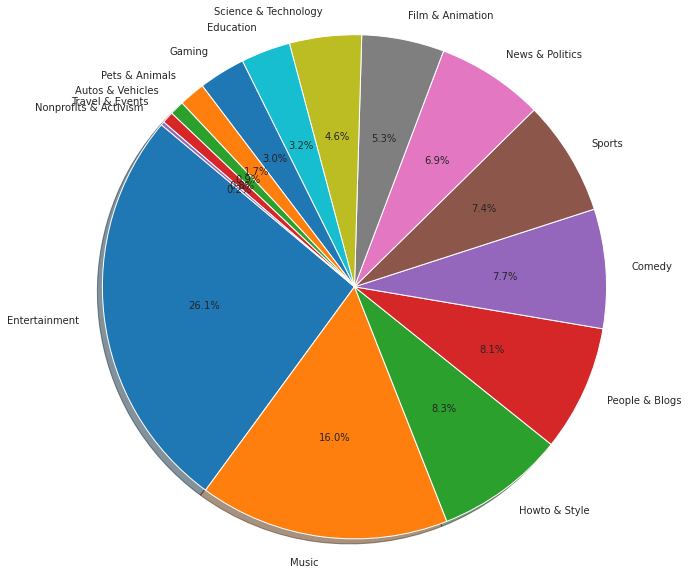

In [52]:
with open("./../../../data/youtube_data/US_category_id.json") as file:
    data = json.loads(file.read())
    
US_cats = {}
for item in data['items']:
    US_cats[item['id']] = item['snippet']['title']

df_temp =df.loc[df['trending'] == 1]

# gbCtr = Counter(df.loc[:, "category_id"]).most_common()
gbCtr = Counter(df_temp.loc[:, "category_id"]).most_common()
gbCatdata = []
gbCatlabels = []
for c in gbCtr:
    try:
        gbCatlabels.append(US_cats[str(int(c[0]))])
        gbCatdata.append(c[1])
    except:
        print("error")


plt.figure(figsize=(10,10))
plt.pie(gbCatdata, labels=gbCatlabels ,autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()


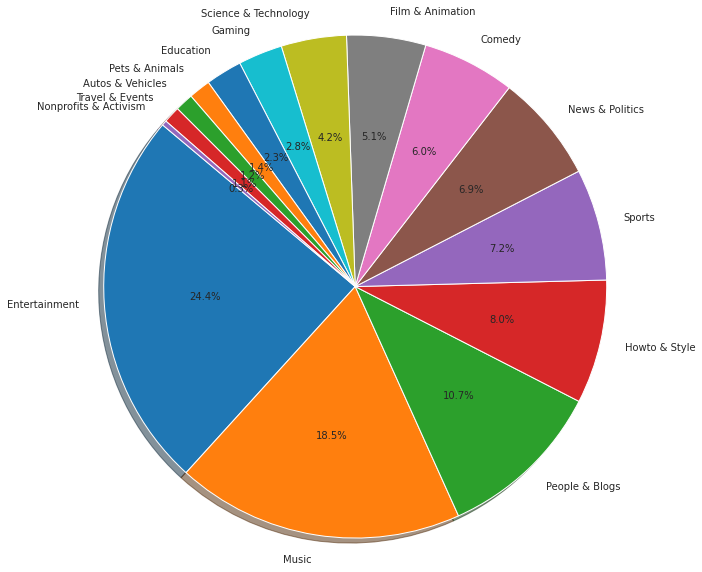

In [53]:
with open("./../../../data/youtube_data/US_category_id.json") as file:
    data = json.loads(file.read())
    
US_cats = {}
for item in data['items']:
    US_cats[item['id']] = item['snippet']['title']



df_temp =df.loc[df['trending'] == 0]

# gbCtr = Counter(df.loc[:, "category_id"]).most_common()
gbCtr = Counter(df_temp.loc[:, "category_id"]).most_common()
gbCatdata = []
gbCatlabels = []
for c in gbCtr:
    try:
        gbCatlabels.append(US_cats[str(int(c[0]))])
        gbCatdata.append(c[1])
    except:
        print("error")


plt.figure(figsize=(10,10))
plt.pie(gbCatdata, labels=gbCatlabels ,autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()


In [54]:
df = pd.read_csv("../../../our_data/Etap5/Etap3/all_no_enc.csv")

NonTrending


,views,likes,dislikes,comment_count
count,8.481000e+03,8.481000e+03,8.481000e+03,8481.000000
mean,5.991002e+06,6.742739e+04,3.142349e+03,3851.847424
std,5.459565e+07,2.825644e+05,8.278180e+04,14660.748861
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
25%,1.472300e+05,2.422000e+03,6.900000e+01,181.000000
50%,7.175060e+05,1.219600e+04,3.240000e+02,823.000000
75%,2.775682e+06,4.579600e+04,1.269000e+03,2840.000000
max,4.018962e+09,1.139208e+07,7.544337e+06,705416.000000


Trending


,views,likes,dislikes,comment_count
count,8.509000e+03,8.509000e+03,8509.000000,8509.000000
mean,8.531435e+05,3.510266e+04,1434.169350,4322.287343
std,2.871638e+06,1.148530e+05,10869.292646,19335.119756
min,5.490000e+02,1.000000e+00,1.000000,1.000000
25%,7.849900e+04,1.872000e+03,66.000000,256.000000
50%,2.529550e+05,7.305000e+03,223.000000,877.000000
75%,7.459640e+05,2.464900e+04,753.000000,2823.000000
max,1.434082e+08,3.880074e+06,629123.000000,733371.000000


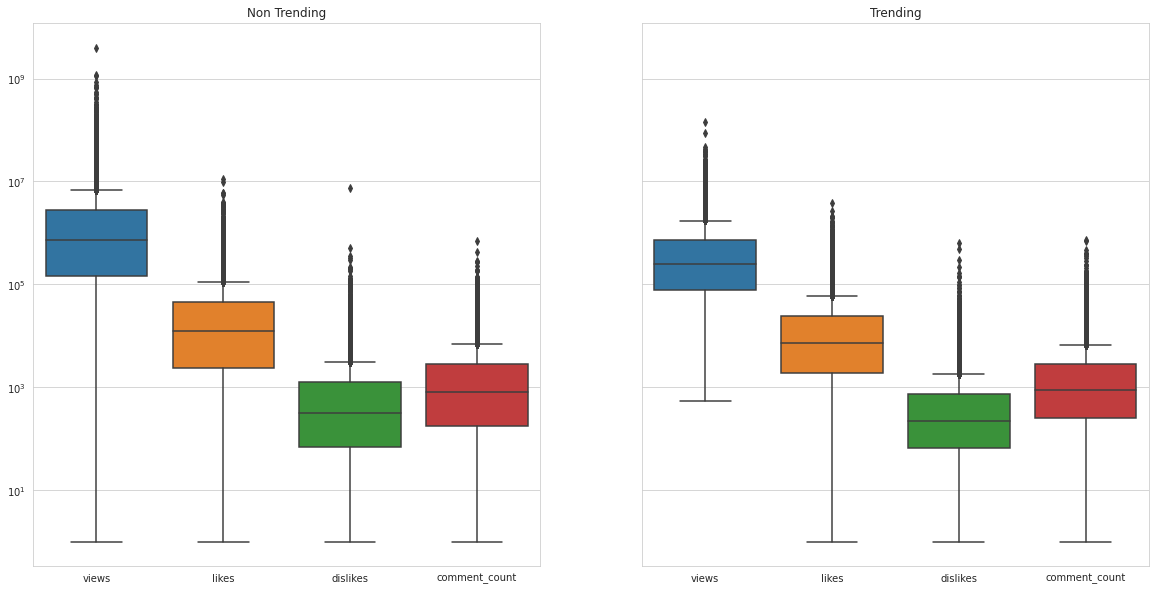

In [55]:
columns = ['views','likes','dislikes','comment_count']

print("NonTrending")
display(df.loc[df['trending'] == 0].describe()[columns])
print("Trending")
display(df.loc[df['trending'] == 1].describe()[columns])


fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True,figsize=(20,10))

sns.set_style("whitegrid")

data = df.loc[df['trending'] == 0][columns]
data2 = df.loc[df['trending'] == 1][columns]

ax1 = sns.boxplot(data=data,ax=ax1)
ax1.set(yscale="log")
ax1.set_title("Non Trending")

ax2 = sns.boxplot(data=data2,ax=ax2)
ax2.set(yscale="log")
ax2.set_title("Trending")
plt.show()

NonTrending


,dislikes/likes,likes/views,dislikes/views,comment_count/views
count,8481.000000,8.481000e+03,8.481000e+03,8.481000e+03
mean,0.062705,2.234318e-02,2.696696e-03,6.333771e+00
std,0.143221,4.670856e-02,4.471832e-02,2.100592e+02
min,0.000860,2.766836e-08,2.766836e-08,2.488205e-10
25%,0.014921,9.493850e-03,2.554324e-04,4.851865e-04
50%,0.027370,1.577304e-02,4.213390e-04,1.157974e-03
75%,0.053454,2.655814e-02,7.206056e-04,2.465090e-03
max,3.259259,1.000000e+00,1.000000e+00,1.437000e+04


Trending


,dislikes/likes,likes/views,dislikes/views,comment_count/views
count,8509.000000,8.509000e+03,8.509000e+03,8.509000e+03
mean,0.117557,4.039033e-02,1.717683e-03,5.740109e-03
std,0.653589,3.513447e-02,4.492533e-03,7.001780e-03
min,0.000576,4.779704e-08,4.779704e-08,4.096206e-08
25%,0.014733,1.431322e-02,5.004658e-04,1.834862e-03
50%,0.030251,3.123913e-02,8.808969e-04,3.758162e-03
75%,0.071256,5.573492e-02,1.626107e-03,6.921355e-03
max,27.931818,2.956704e-01,2.155757e-01,1.176430e-01


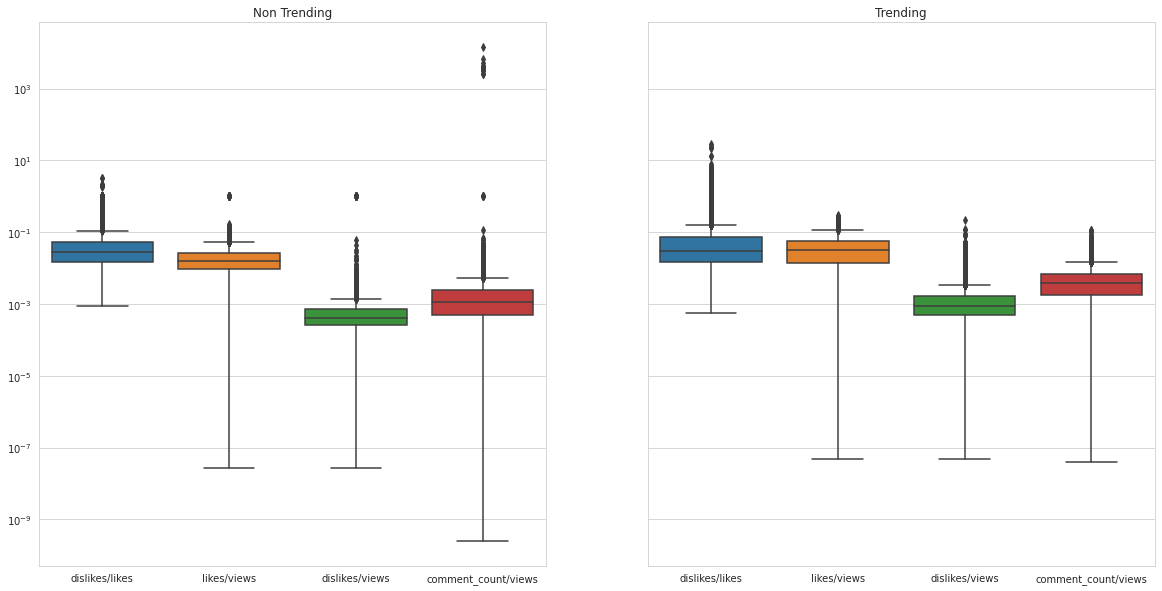

In [56]:

columns = ['dislikes/likes','likes/views','dislikes/views','comment_count/views']

print("NonTrending")
display(df.loc[df['trending'] == 0].describe()[columns])
print("Trending")
display(df.loc[df['trending'] == 1].describe()[columns])

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True,figsize=(20,10))

sns.set_style("whitegrid")

data = df.loc[df['trending'] == 0][columns]
data2 = df.loc[df['trending'] == 1][columns]

ax1 = sns.boxplot(data=data,ax=ax1)
ax1.set(yscale="log")
ax1.set_title("Non Trending")

ax2 = sns.boxplot(data=data2,ax=ax2)
ax2.set(yscale="log")
ax2.set_title("Trending")
plt.show()

NonTrending


,Sad,Fear,Angry,Happy,Neutral,Surprise
count,8480.000000,8480.000000,8480.000000,8480.000000,8480.000000,8480.000000
mean,0.344104,0.103656,0.263208,0.488090,0.312500,0.016274
std,0.775852,0.350204,0.648923,0.875072,0.643939,0.131111
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,17.000000,5.000000,13.000000,13.000000,11.000000,2.000000


Trending


,Sad,Fear,Angry,Happy,Neutral,Surprise
count,7710.000000,7710.000000,7710.000000,7710.000000,7710.000000,7710.000000
mean,0.315953,0.094942,0.225162,0.461997,0.279637,0.013100
std,0.715118,0.330980,0.559023,0.840841,0.584211,0.118185
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,15.000000,3.000000,8.000000,18.000000,6.000000,2.000000


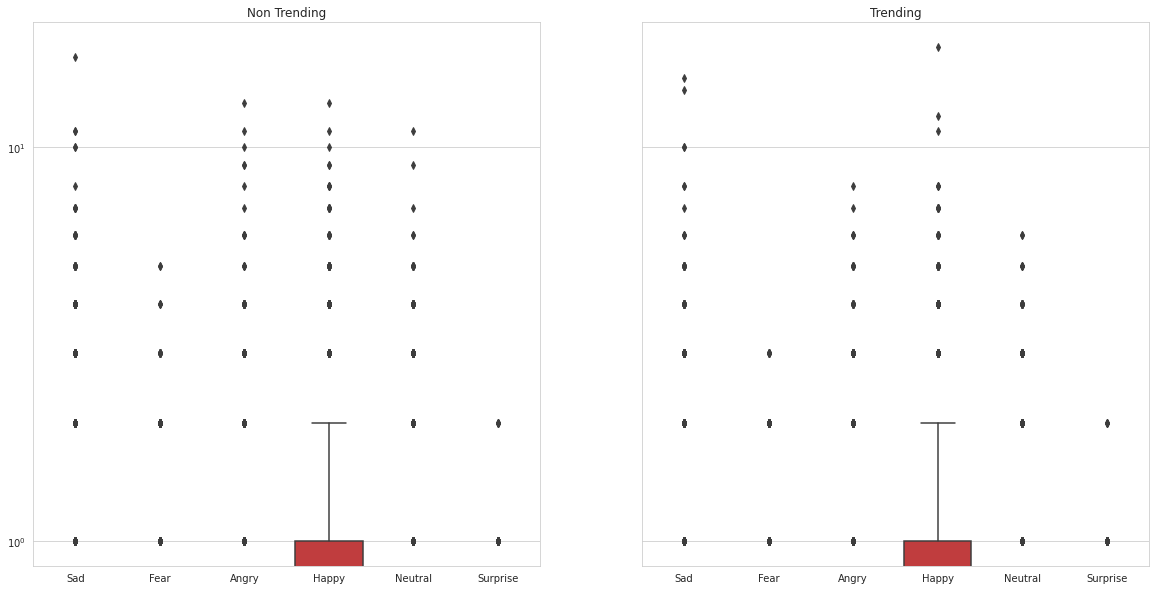

In [57]:

columns = ['Sad', 'Fear', 'Angry', 'Happy', 'Neutral', 'Surprise']

print("NonTrending")
display(df.loc[df['trending'] == 0].describe()[columns])
print("Trending")
display(df.loc[df['trending'] == 1].describe()[columns])

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True,figsize=(20,10))

sns.set_style("whitegrid")

data = df.loc[df['trending'] == 0][columns]
data2 = df.loc[df['trending'] == 1][columns]

ax1 = sns.boxplot(data=data,ax=ax1)
ax1.set(yscale="log")
ax1.set_title("Non Trending")

ax2 = sns.boxplot(data=data2,ax=ax2)
ax2.set(yscale="log")
ax2.set_title("Trending")
plt.show()

NonTrending


,mean_h,mean_s,mean_v
count,8480.000000,8480.000000,8480.000000
mean,0.291206,0.315149,0.382592
std,0.133575,0.135640,0.137380
min,0.000000,0.000000,0.000000
25%,0.190824,0.224933,0.287726
50%,0.283469,0.311179,0.380687
75%,0.387176,0.398244,0.478710
max,0.741190,0.963448,0.898738


Trending


,mean_h,mean_s,mean_v
count,7713.000000,7713.000000,7713.000000
mean,0.287807,0.307732,0.382307
std,0.130228,0.134420,0.134135
min,0.000000,0.000000,0.002501
25%,0.189758,0.214250,0.287948
50%,0.280416,0.301458,0.383755
75%,0.378624,0.390911,0.476409
max,0.791519,0.845765,0.861026


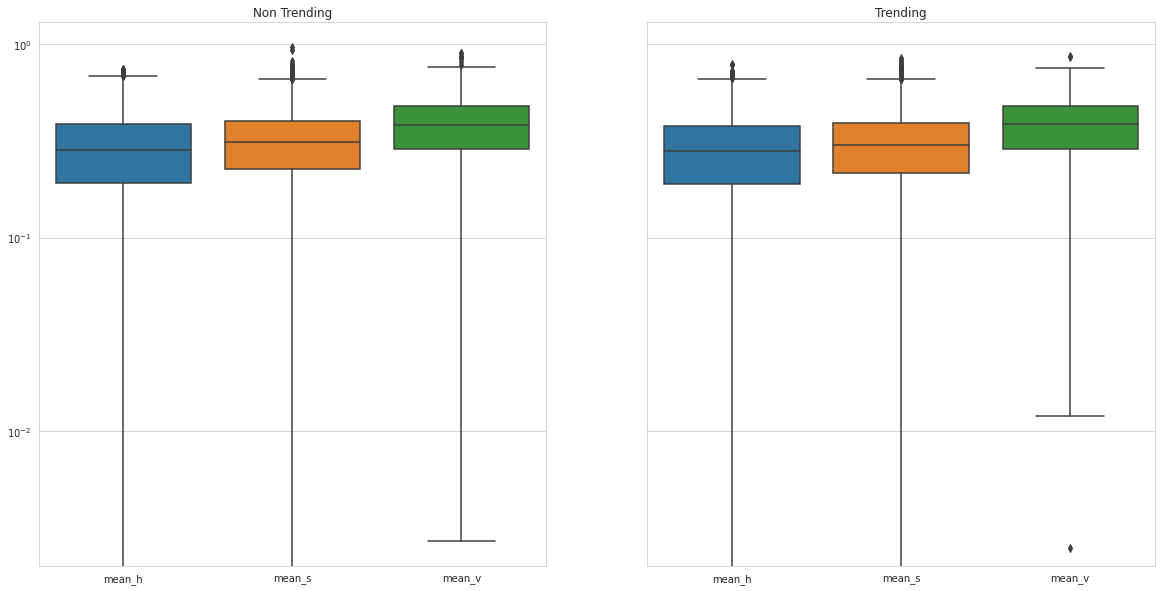

In [58]:

columns = ['mean_h', 'mean_s', 'mean_v']

print("NonTrending")
display(df.loc[df['trending'] == 0].describe()[columns])
print("Trending")
display(df.loc[df['trending'] == 1].describe()[columns])

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True,figsize=(20,10))

sns.set_style("whitegrid")

data = df.loc[df['trending'] == 0][columns]
data2 = df.loc[df['trending'] == 1][columns]

ax1 = sns.boxplot(data=data,ax=ax1)
ax1.set(yscale="log")
ax1.set_title("Non Trending")

ax2 = sns.boxplot(data=data2,ax=ax2)
ax2.set(yscale="log")
ax2.set_title("Trending")
plt.show()

NonTrending


,avg_texts_coordX,avg_texts_coordY
count,8481.000000,8481.000000
mean,149.348388,151.899574
std,123.576918,106.538512
min,-1.000000,-1.000000
25%,-1.000000,-1.000000
50%,142.000000,178.000000
75%,242.500000,251.000000
max,466.500000,344.000000


Trending


,avg_texts_coordX,avg_texts_coordY
count,7710.000000,7710.000000
mean,136.774230,154.178412
std,119.450686,109.873628
min,-1.000000,-1.000000
25%,-1.000000,-1.000000
50%,120.000000,180.354167
75%,234.028846,256.812500
max,470.500000,350.500000


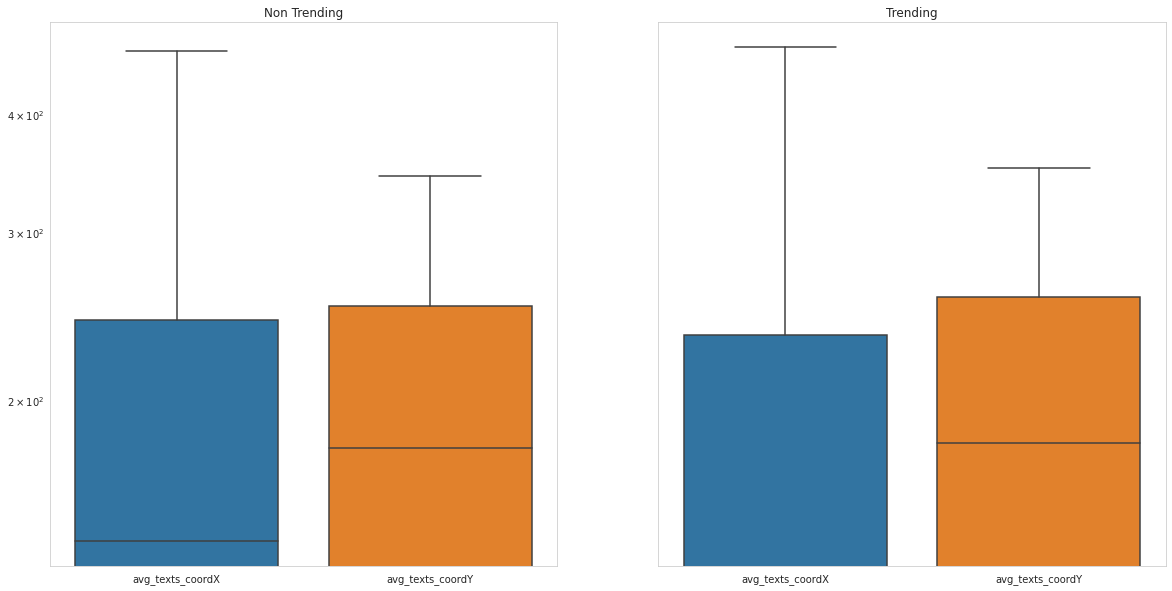

In [59]:

columns = ['avg_texts_coordX', 'avg_texts_coordY']

print("NonTrending")
display(df.loc[df['trending'] == 0].describe()[columns])
print("Trending")
display(df.loc[df['trending'] == 1].describe()[columns])

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True,figsize=(20,10))

sns.set_style("whitegrid")

data = df.loc[df['trending'] == 0][columns]
data2 = df.loc[df['trending'] == 1][columns]

ax1 = sns.boxplot(data=data,ax=ax1)
ax1.set(yscale="log")
ax1.set_title("Non Trending")

ax2 = sns.boxplot(data=data2,ax=ax2)
ax2.set(yscale="log")
ax2.set_title("Trending")
plt.show()

NonTrending


,title_length,title_n_of_words,title_capital_letters,title_capital_letters_percent,title_small_letters,title_small_letters_percent,title_punctuation,title_punctuation_percent,title_n_of_emojis
count,8481.000000,8481.000000,8481.000000,8481.000000,8481.000000,8481.000000,8481.000000,8481.000000,8481.000000
mean,52.269190,9.112723,10.715128,0.216210,29.643556,0.557037,2.434383,0.046601,0.016743
std,20.060946,3.583180,8.650634,0.176585,15.429478,0.191294,2.054956,0.037157,0.168099
min,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37.000000,6.000000,6.000000,0.128205,20.000000,0.512821,1.000000,0.020408,0.000000
50%,50.000000,9.000000,8.000000,0.156863,29.000000,0.609195,2.000000,0.041096,0.000000
75%,65.000000,11.000000,13.000000,0.216216,40.000000,0.672131,3.000000,0.067797,0.000000
max,112.000000,24.000000,75.000000,1.000000,78.000000,0.928571,18.000000,0.272727,5.000000


Trending


,title_length,title_n_of_words,title_capital_letters,title_capital_letters_percent,title_small_letters,title_small_letters_percent,title_punctuation,title_punctuation_percent,title_n_of_emojis
count,8509.000000,8509.000000,8509.000000,8509.000000,8509.000000,8509.000000,8509.000000,8509.000000,8509.000000
mean,50.175931,8.808086,10.080738,0.211655,29.150076,0.570934,2.040898,0.040973,0.019156
std,19.853446,3.565421,8.300860,0.176315,15.351528,0.192808,1.750001,0.034886,0.194505
min,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,6.000000,5.000000,0.127273,19.000000,0.534884,1.000000,0.016129,0.000000
50%,48.000000,8.000000,8.000000,0.156250,29.000000,0.623188,2.000000,0.035714,0.000000
75%,63.000000,11.000000,12.000000,0.205882,39.000000,0.684211,3.000000,0.060000,0.000000
max,100.000000,24.000000,78.000000,0.947368,80.000000,1.000000,12.000000,0.318182,6.000000


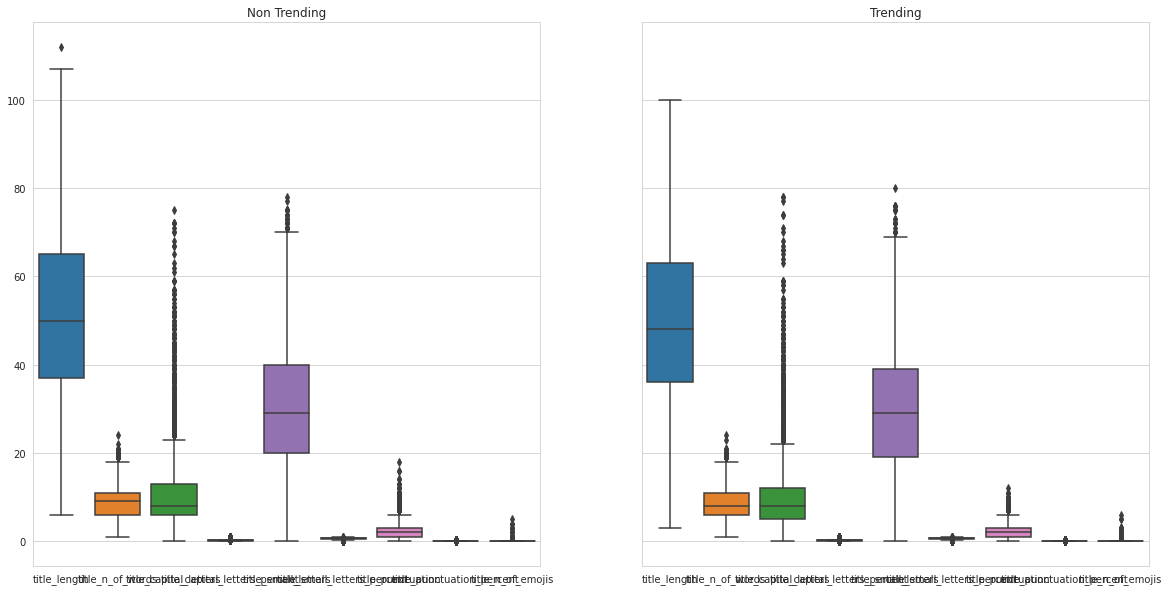

In [60]:
columns = [        'title_length', 'title_n_of_words',
       'title_capital_letters', 'title_capital_letters_percent',
       'title_small_letters', 'title_small_letters_percent',
       'title_punctuation', 'title_punctuation_percent',
       'title_n_of_emojis']

print("NonTrending")
display(df.loc[df['trending'] == 0].describe()[columns])
print("Trending")
display(df.loc[df['trending'] == 1].describe()[columns])

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True,figsize=(20,10))

sns.set_style("whitegrid")

data = df.loc[df['trending'] == 0][columns]
data2 = df.loc[df['trending'] == 1][columns]

ax1 = sns.boxplot(data=data,ax=ax1)
# ax1.set(yscale="log")
ax1.set_title("Non Trending")

ax2 = sns.boxplot(data=data2,ax=ax2)
# ax2.set(yscale="log")
ax2.set_title("Trending")
plt.show()

In [61]:
data.describe()

,title_length,title_n_of_words,title_capital_letters,title_capital_letters_percent,title_small_letters,title_small_letters_percent,title_punctuation,title_punctuation_percent,title_n_of_emojis
count,8481.000000,8481.000000,8481.000000,8481.000000,8481.000000,8481.000000,8481.000000,8481.000000,8481.000000
mean,52.269190,9.112723,10.715128,0.216210,29.643556,0.557037,2.434383,0.046601,0.016743
std,20.060946,3.583180,8.650634,0.176585,15.429478,0.191294,2.054956,0.037157,0.168099
min,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37.000000,6.000000,6.000000,0.128205,20.000000,0.512821,1.000000,0.020408,0.000000
50%,50.000000,9.000000,8.000000,0.156863,29.000000,0.609195,2.000000,0.041096,0.000000
75%,65.000000,11.000000,13.000000,0.216216,40.000000,0.672131,3.000000,0.067797,0.000000
max,112.000000,24.000000,75.000000,1.000000,78.000000,0.928571,18.000000,0.272727,5.000000


In [62]:
data2.describe()

,title_length,title_n_of_words,title_capital_letters,title_capital_letters_percent,title_small_letters,title_small_letters_percent,title_punctuation,title_punctuation_percent,title_n_of_emojis
count,8509.000000,8509.000000,8509.000000,8509.000000,8509.000000,8509.000000,8509.000000,8509.000000,8509.000000
mean,50.175931,8.808086,10.080738,0.211655,29.150076,0.570934,2.040898,0.040973,0.019156
std,19.853446,3.565421,8.300860,0.176315,15.351528,0.192808,1.750001,0.034886,0.194505
min,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,6.000000,5.000000,0.127273,19.000000,0.534884,1.000000,0.016129,0.000000
50%,48.000000,8.000000,8.000000,0.156250,29.000000,0.623188,2.000000,0.035714,0.000000
75%,63.000000,11.000000,12.000000,0.205882,39.000000,0.684211,3.000000,0.060000,0.000000
max,100.000000,24.000000,78.000000,0.947368,80.000000,1.000000,12.000000,0.318182,6.000000


In [92]:


df = pd.read_csv("../../../our_data/Etap5/Etap3/all_for_FI.csv")

del df['video_id']
df = df.fillna(-1)

# for col in df.columns:
#     temp = df[col].isna()
#     print(f"{col}:, {temp.any()} {temp.sum()}")

from sklearn.model_selection import train_test_split
test_unlabeled_size = 0.3

X_train, X_test, y_train, y_test = \
                                    train_test_split(df.loc[:,~df.columns.isin(['trending'])], 
                                                     df['trending'], 
                                                     test_size=test_unlabeled_size)

print(f'X_train_unlabeled: ', X_train.shape)
print(f'y_train_unlabeled: ', y_train.shape)
print(f'X_test_unlabeled: ', X_test.shape)
print(f'y_test_unlabeled: ', y_test.shape)

X_train_unlabeled:  (11893, 53)
y_train_unlabeled:  (11893,)
X_test_unlabeled:  (5097, 53)
y_test_unlabeled:  (5097,)


In [87]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression



k_best_columns = 20


model = LogisticRegression(n_jobs=-1, max_iter=1000)
model.fit(X_train, y_train)

yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
print(f'accuracy: {score*100}%')

from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, X_test, y_test)  
plt.show()  

accuracy: 74.90680792623111%


In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


model = RandomForestClassifier()

model.fit(X_train, y_train)

yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
print(f'accuracy: {score*100}%')

plot_confusion_matrix(model, X_test, y_test)  
plt.show()  

accuracy: 82.42103197959584%


In [104]:
columns = ['category_id',
 'views',
 'likes',
 'dislikes',
 'comment_count',
#  'pub_day_of_the_week',
#  'pub_day',
#  'pub_hour',
 'dislikes/likes',
 'likes/views',
 'dislikes/views',
 'comment_count/views',
#  'n_of_tags',
#  'title_length',
#  'title_n_of_words',
#  'title_capital_letters',
#  'title_capital_letters_percent',
#  'title_small_letters',
#  'title_small_letters_percent',
#  'title_punctuation',
#  'title_punctuation_percent',
#  'title_n_of_emojis',
#  'desc_length',
#  'desc_n_of_words',
#  'desc_capital_letters',
#  'desc_capital_letters_percent',
#  'desc_small_letters',
#  'desc_small_letters_percent',
#  'desc_punctuation',
#  'desc_punctuation_percent',
#  'desc_n_of_urls',
#  'desc_n_of_emojis',
#  'isFacebook',
#  'isTwitter',
#  'isInstagram',
#  'mean_h',
#  'mean_s',
#  'mean_v',
#  'std_h',
#  'std_s',
#  'std_v',
#  'entropy',
#  'avg_texts_coordX',
#  'avg_texts_coordY',
#  'ocr_sentiment_compound',
#  'Sad',
#  'Fear',
#  'Angry',
#  'Happy',
#  'Neutral',
#  'Surprise',
#  'people',
#  'faces',
 'trending'
          ]


In [105]:
df = pd.read_csv("../../../our_data/Etap5/Etap3/all_for_FI.csv")

del df['video_id']
df = df.fillna(-1)

df = df.loc[:,columns]

# for col in df.columns:
#     temp = df[col].isna()
#     print(f"{col}:, {temp.any()} {temp.sum()}")

from sklearn.model_selection import train_test_split
test_unlabeled_size = 0.3

X_train, X_test, y_train, y_test = \
                                    train_test_split(df.loc[:,~df.columns.isin(['trending'])], 
                                                     df['trending'], 
                                                     test_size=test_unlabeled_size)

print(f'X_train_unlabeled: ', X_train.shape)
print(f'y_train_unlabeled: ', y_train.shape)
print(f'X_test_unlabeled: ', X_test.shape)
print(f'y_test_unlabeled: ', y_test.shape)

X_train_unlabeled:  (11893, 9)
y_train_unlabeled:  (11893,)
X_test_unlabeled:  (5097, 9)
y_test_unlabeled:  (5097,)


accuracy: 75.27957622130666%


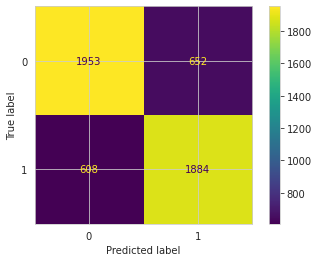

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


model = RandomForestClassifier()

model.fit(X_train, y_train)

yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
print(f'accuracy: {score*100}%')

plot_confusion_matrix(model, X_test, y_test)  
plt.show()  